Using device: cpu
Epoch     1 | total 2.008e+06 | pde 4.163e-01 | term 2.005e+04 | data 3.702e+03
Epoch   200 | total 1.691e+06 | pde 1.068e+01 | term 1.689e+04 | data 2.750e+03
Epoch   400 | total 1.463e+06 | pde 2.095e+01 | term 1.461e+04 | data 1.946e+03
Epoch   600 | total 1.272e+06 | pde 2.444e+01 | term 1.270e+04 | data 1.421e+03
Epoch   800 | total 1.107e+06 | pde 9.823e+00 | term 1.106e+04 | data 1.027e+03
Epoch  1000 | total 9.648e+05 | pde 1.291e+01 | term 9.640e+03 | data 7.251e+02
Epoch  1200 | total 8.400e+05 | pde 1.372e+01 | term 8.395e+03 | data 4.966e+02
Epoch  1400 | total 7.308e+05 | pde 1.131e+01 | term 7.305e+03 | data 3.263e+02
Epoch  1600 | total 6.350e+05 | pde 1.087e+01 | term 6.348e+03 | data 2.028e+02
Epoch  1800 | total 5.511e+05 | pde 1.180e+01 | term 5.510e+03 | data 1.168e+02
Epoch  2000 | total 4.774e+05 | pde 1.035e+01 | term 4.774e+03 | data 6.067e+01
Epoch  2200 | total 4.129e+05 | pde 9.929e+00 | term 4.128e+03 | data 2.710e+01
Epoch  2400 | total 3.

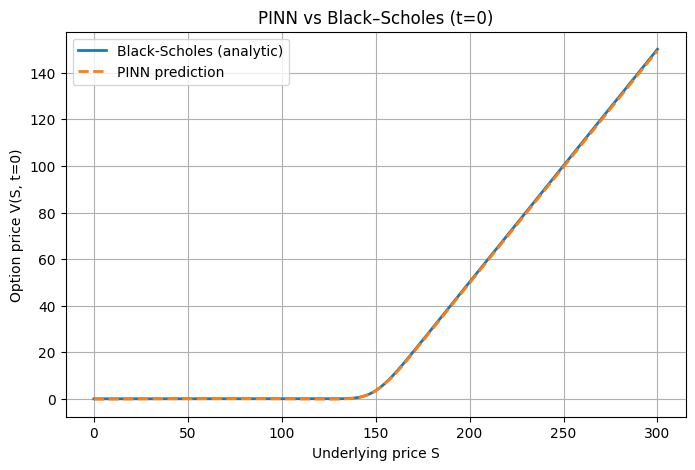

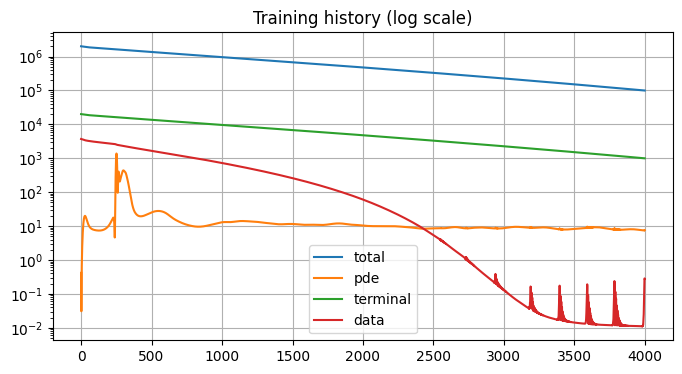

In [2]:
# pinn_black_scholes.py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
import math
import random

# ---------------------
# Repro / device
# ---------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------
# Problem / training params
# ---------------------
K_val = 150.0                # strike used for synthetic/demo data (can be vectorized)
r_val = 0.01                 # risk-free rate
sigma_const = 0.2            # constant vol used for mock data
T_maturity = 30.0 / 365.0    # maturity (years)
use_real_market_data = False # set True and plug your data-loading to use market prices

# Training hyperparams
n_collocation = 3000     # PDE collocation points
n_terminal = 400         # terminal condition points
n_data = 600             # optional market/data points
n_epochs = 4000
lr = 1e-3

pde_weight = 1.0
term_weight = 100.0
data_weight = 1.0

# Scaling factors: scale S by K and t by T for better training
def scale_inputs(S, t, K, T):
    # expects tensors (N,1)
    return S / (K + 1e-12), t / (T + 1e-12)

# ---------------------
# PINN model: inputs (S_scaled, t_scaled, sigma_scaled)
# You can include K or r as inputs if you intend a single model across strikes/rates
# ---------------------
class PINN(nn.Module):
    def __init__(self, input_dim=3, width=64, depth=3):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.Tanh())
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, S, t, sigma):
        # inputs are column tensors (N,1)
        x = torch.cat([S, t, sigma], dim=1)
        return self.net(x)

# ---------------------
# Black-Scholes analytic price (PyTorch) for reference / data generation
# Uses current time t and maturity T
# ---------------------
def bs_price_call_torch(S, K, t, T, r, sigma):
    eps = 1e-8
    tau = (T - t).clamp(min=eps)         # time-to-maturity
    sqrt_tau = torch.sqrt(tau)
    d1 = (torch.log(S / (K + 1e-16)) + (r + 0.5 * sigma ** 2) * tau) / (sigma * sqrt_tau + 1e-16)
    d2 = d1 - sigma * sqrt_tau
    norm = Normal(0.0, 1.0)
    cdf_d1 = norm.cdf(d1)
    cdf_d2 = norm.cdf(d2)
    price = S * cdf_d1 - K * torch.exp(-r * tau) * cdf_d2
    intrinsic = torch.maximum(S - K, torch.zeros_like(S))
    price = torch.where(tau < 1e-6, intrinsic, price)
    return price

# ---------------------
# PDE residual (Black-Scholes)
# PDE: V_t + 0.5*sigma^2*S^2*V_SS + r*S*V_S - r*V = 0
# Note: we compute derivatives with respect to S and t (current time).
# ---------------------
def pde_residual(model, S, t, sigma, r):
    # Ensure S and t require gradients for autograd
    S_req = S.clone().detach().to(device).requires_grad_(True)
    t_req = t.clone().detach().to(device).requires_grad_(True)
    sigma_in = sigma.clone().detach().to(device)

    V = model(S_req, t_req, sigma_in)  # (N,1)

    # first derivatives
    V_S = torch.autograd.grad(V, S_req, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_t = torch.autograd.grad(V, t_req, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    # second derivative
    V_SS = torch.autograd.grad(V_S, S_req, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5 * (sigma_in ** 2) * (S_req ** 2) * V_SS + r * S_req * V_S - r * V
    return residual

# ---------------------
# Terminal loss: enforce V(S, T) = max(S - K, 0)
# ---------------------
def terminal_loss(model, S_samples, K, r, sigma, T):
    t_T = torch.full_like(S_samples, T, device=device)
    V_pred_T = model(S_samples.to(device), t_T, sigma.to(device))
    payoff = torch.maximum(S_samples.to(device) - K.to(device), torch.zeros_like(S_samples.to(device)))
    return torch.mean((V_pred_T - payoff) ** 2)

# ---------------------
# Sampling helpers
# ---------------------
def sample_collocation(n, S_min, S_max, T):
    S = torch.rand((n, 1), device=device) * (S_max - S_min) + S_min
    t = torch.rand((n, 1), device=device) * (T - 0.0)
    return S, t

def make_mock_market_data(n, S_min, S_max, K, T, r, sigma):
    S = torch.rand((n, 1), device=device) * (S_max - S_min) + S_min
    t_now = torch.rand((n, 1), device=device) * (T - 0.0)
    K_tensor = torch.full_like(S, K, device=device)
    sigma_t = torch.full_like(S, sigma, device=device)
    prices = bs_price_call_torch(S, K_tensor, t_now, T, r, sigma_t)
    return S, t_now, K_tensor, sigma_t, prices

# ---------------------
# Build model and data (mock by default)
# ---------------------
model = PINN(input_dim=3, width=64, depth=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Collocation (PDE) points
S_min, S_max = 0.01, 3.0 * K_val
S_coll, t_coll = sample_collocation(n_collocation, S_min, S_max, T_maturity)
K_coll = torch.full_like(S_coll, K_val, device=device)
r_coll = torch.full_like(S_coll, r_val, device=device)
sigma_coll = torch.full_like(S_coll, sigma_const, device=device)

# Terminal condition samples
S_terminal = torch.linspace(0.01, 3.0 * K_val, n_terminal, device=device).view(-1, 1)
K_term = torch.full_like(S_terminal, K_val, device=device)
sigma_term = torch.full_like(S_terminal, sigma_const, device=device)
r_term = torch.full_like(S_terminal, r_val, device=device)

# Data (market) points - mock / can replace with real market arrays
if not use_real_market_data:
    S_data, t_data, K_data, sigma_data, price_data = make_mock_market_data(n_data, 0.1, 2.0 * K_val, K_val, T_maturity, r_val, sigma_const)
else:
    # Placeholder for loading real market data:
    # Load arrays: S_data, t_data, K_data, sigma_data, price_data (all (N,1) tensors on device)
    raise NotImplementedError("Set use_real_market_data=False or implement market-data loading here.")

# Optional: scale inputs (improves training)
# We'll scale S by K and t by T before passing to the network.
def prepare_input_tensors(S, t, K, T):
    S_scaled, t_scaled = scale_inputs(S, t, K, T)
    # also scale sigma by a reasonable factor (for now divide by 0.5 to keep ~O(1))
    sigma_scaled = sigma_const / 0.5 if isinstance(sigma_const, float) else torch.ones_like(S) * (sigma_const / 0.5)
    # For consistency, create tensor with per-sample sigma values if needed:
    return S_scaled.to(device), t_scaled.to(device), torch.full_like(S_scaled, sigma_scaled, device=device)

# But the model forward expects (S_scaled, t_scaled, sigma_scaled)
# We'll create helper wrappers that scale on the fly

def model_forward_scaled(raw_S, raw_t, raw_sigma, K_ref, T_ref):
    S_s = (raw_S / (K_ref + 1e-12)).to(device)
    t_s = (raw_t / (T_ref + 1e-12)).to(device)
    sigma_s = (raw_sigma / 0.5).to(device)  # normalize sigma ~0.2 => 0.4
    return model(S_s, t_s, sigma_s)

# ---------------------
# Training loop
# ---------------------
history = {'loss': [], 'pde': [], 'term': [], 'data': []}

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Scale collocation inputs
    S_coll_scaled = (S_coll / (K_coll + 1e-12)).to(device)
    t_coll_scaled = (t_coll / (T_maturity + 1e-12)).to(device)
    sigma_coll_scaled = (sigma_coll / 0.5).to(device)  # scale sigma

    # Compute PDE residual using unscaled S,t for derivatives (autograd works best on physical variables)
    # So we call pde_residual with physical S,t,sigma but the model itself expects scaled inputs.
    # We'll wrap a small helper model that performs scaling inside the call.
    def wrapped_model(S_phys, t_phys, sigma_phys):
        S_s = (S_phys / (K_coll + 1e-12))
        t_s = (t_phys / (T_maturity + 1e-12))
        sigma_s = (sigma_phys / 0.5)
        return model(S_s.to(device), t_s.to(device), sigma_s.to(device))

    residual = pde_residual(wrapped_model, S_coll, t_coll, sigma_coll, r_val)
    L_pde = torch.mean(residual**2)

    # Terminal loss: use physical S but model scales internally
    S_T_phys = S_terminal
    t_T_phys = torch.full_like(S_T_phys, T_maturity, device=device)
    sigma_T = sigma_term
    def wrapped_model_T(S_phys, t_phys, sigma_phys):
        S_s = (S_phys / (K_term + 1e-12))
        t_s = (t_phys / (T_maturity + 1e-12))
        sigma_s = (sigma_phys / 0.5)
        return model(S_s.to(device), t_s.to(device), sigma_s.to(device))
    L_term = terminal_loss(wrapped_model_T, S_T_phys, K_term, r_val, sigma_term, T_maturity)

    # Data loss (if any): compare model predictions to market/BS prices
    S_data_phys = S_data
    t_data_phys = t_data
    sigma_data_phys = sigma_data
    # forward (scale inside)
    S_s = (S_data_phys / (K_data + 1e-12)).to(device)
    t_s = (t_data_phys / (T_maturity + 1e-12)).to(device)
    sigma_s = (sigma_data_phys / 0.5).to(device)
    V_pred_data = model(S_s, t_s, sigma_s)
    L_data = torch.mean((V_pred_data - price_data) ** 2)

    loss = pde_weight * L_pde + term_weight * L_term + data_weight * L_data

    loss.backward()
    optimizer.step()

    history['loss'].append(loss.item())
    history['pde'].append(L_pde.item())
    history['term'].append(L_term.item())
    history['data'].append(L_data.item())

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | total {loss.item():.3e} | pde {L_pde.item():.3e} | term {L_term.item():.3e} | data {L_data.item():.3e}")

# ---------------------
# Evaluate & plot
# ---------------------
model.eval()
# Evaluate at t=0 (today) across S-grid and compare to analytic BS
S_grid_phys = torch.linspace(0.01, 2.0 * K_val, 300, device=device).view(-1, 1)
t_zero_phys = torch.zeros_like(S_grid_phys, device=device)
K_grid = torch.full_like(S_grid_phys, K_val, device=device)
sigma_grid = torch.full_like(S_grid_phys, sigma_const, device=device)

# scaled inputs
S_grid_s = (S_grid_phys / (K_grid + 1e-12))
t_grid_s = (t_zero_phys / (T_maturity + 1e-12))
sigma_grid_s = (sigma_grid / 0.5)

with torch.no_grad():
    V_pred = model(S_grid_s.to(device), t_grid_s.to(device), sigma_grid_s.to(device)).cpu().numpy().flatten()
    V_true = bs_price_call_torch(S_grid_phys.cpu(), K_grid.cpu(), t_zero_phys.cpu(), T_maturity, r_val, sigma_grid.cpu()).cpu().numpy().flatten()

plt.figure(figsize=(8,5))
plt.plot(S_grid_phys.cpu().numpy(), V_true, label='Black-Scholes (analytic)', linewidth=2)
plt.plot(S_grid_phys.cpu().numpy(), V_pred, '--', label='PINN prediction', linewidth=2)
plt.xlabel('Underlying price S')
plt.ylabel('Option price V(S, t=0)')
plt.title('PINN vs Black–Scholes (t=0)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.semilogy(history['loss'], label='total')
plt.semilogy(history['pde'], label='pde')
plt.semilogy(history['term'], label='terminal')
plt.semilogy(history['data'], label='data')
plt.legend(); plt.title('Training history (log scale)')
plt.grid(True)
plt.show()
